<a href="https://colab.research.google.com/github/p1atdev/LECO/blob/dev/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 準備

In [ ]:
!git clone https://github.com/p1atdev/LECO
%cd LECO

In [ ]:
%pip install xformers
%pip install -r requirements.txt

## 学習の設定 (簡易)

### モデルの例

- SDv1.5: `runwayml/stable-diffusion-v1-5`
- SDv2.1-768: `stabilityai/stable-diffusion-2-1`
- WD1.5 beta3: `Birchlabs/wd-1-5-beta3-unofficial`
- 多分.safetensors直リンクでもいける: `https://huggingface.co/stabilityai/stable-diffusion-2-1/resolve/main/v2-1_768-ema-pruned.ckpt`

In [ ]:
pretrained_sd_model = "runwayml/stable-diffusion-v1-5"  #@param {type: "string"}
is_v2_model = "false" #@param ["true", "false"]
is_v_prediction_model = "false" #@param ["true", "false"]

#@markdown ---

target_concept = 'van gogh'  #@param {type: "string"}

resolution = 512 #@param [512, 640, 768, 896, 960, 1024]
batch_size = 1  #@param {type: "number"}
iterations = 1000  #@param {type: "number"}

#@markdown ---

save_per_steps = 100  #@param {type: "number"}

#@markdown ---

verbose = "false" #@param ["true", "false"]


#@markdown wandb を使わない場合は空でOK

#@markdown トークン: https://wandb.ai/authorize

wandb_token = "" #@param {type: "string"}

# ------------

save_name = target_concept.replace(" ", "_")

config_file_path = "/content/config.yaml"
prompts_file_path = "/content/prompts.yaml"


config_file_content = f"""
prompts_file: "{prompts_file_path}"

pretrained_model:
  name_or_path: "{pretrained_sd_model}"
  v2: {is_v2_model}
  v_pred: {is_v_prediction_model}

network:
  type: "lierla"
  rank: 16
  alpha: 1.0

train:
  precision: "float32"
  noise_scheduler: "ddim"
  iterations: {iterations}
  batch_size: {batch_size}
  lr: 1e-4
  optimizer: "AdamW"
  lr_scheduler: "constant"

save:
  name: "{save_name}"
  path: "/content/output/{save_name}"
  per_steps: {save_per_steps}
  precision: "float32"

logging:
  use_wandb: {"true" if wandb_token != "" else "false"}
  verbose: {verbose}

other:
  use_xformers: true
"""

with open(config_file_path, "w") as f:
  f.write(config_file_content)

prompts_file_content = f"""
- target: "{target_concept}"
  positive: "{target_concept}"
  unconditional: ""
  neutral: ""
  action: "erase"
  guidance_scale: 1.0
  resolution: {resolution}
  batch_size: {batch_size}
"""

with open(prompts_file_path, "w") as f:
  f.write(prompts_file_content)

if wandb_token != "": # ログイン
  !wandb login {wandb_token}


## 学習！

In [ ]:
!python ./train_lora.py --config_file "/content/config.yaml"

## 実際に生成 (簡易)

In [ ]:
#@title LoRA の読み込み

import torch
from diffusers import DiffusionPipeline
import copy
import gc

def flush():
  torch.cuda.empty_cache()
  gc.collect()

flush()

#@markdown 作成されたLoRAのパス
path_to_lora = "/content/output/van_gogh/van_gogh_sdv15.safetensors" #@param {"type": "string"}

pipe = DiffusionPipeline.from_pretrained(
    pretrained_sd_model,
    custom_pipeline="lpw_stable_diffusion",
    torch_dtype=torch.float16
)

pipe = pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

orig_unet = copy.deepcopy(pipe.unet)

pipe.load_lora_weights(path_to_lora)

lora_unet = copy.deepcopy(pipe.unet)


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

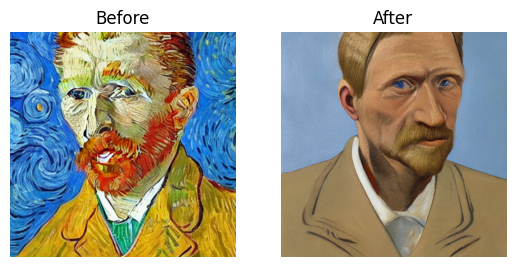

In [ ]:
#@title 生成

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

prompt = "oil painting of van gogh by himself" #@param {"type": "string"}

negative_prompt = "low quality, ugly, horror, blurry" #@param {"type": "string"}

width = 512 #@param {type: "number"}
height = 512 #@param {type: "number"}


steps = 20  #@param {type:"slider", min:1, max:50, step:1}
cfg_scale = 7 #@param {type:"slider", min:1, max:16, step:0.5}

# 適当なシード(揃える)
random_seed = random.randint(0, 2**32 - 1)

# -------
# 通常時

pipe.unet = orig_unet

orig_sample = pipe.text2img(
    prompt,
    negative_prompt=negative_prompt,
    width=width,
    height=height,
    num_inference_steps=steps,
    guidance_scale=cfg_scale,
    generator=torch.manual_seed(random_seed),
).images[0]


# -------
# 適用時

pipe.unet = lora_unet

lora_sample = pipe.text2img(
    prompt,
    negative_prompt=negative_prompt,
    width=width,
    height=height,
    num_inference_steps=steps,
    guidance_scale=cfg_scale,
    generator=torch.manual_seed(random_seed),
).images[0]


# ---

fig, ax = plt.subplots(1, 2)

ax[0].imshow(orig_sample)
ax[0].set_title('Before')
ax[0].axis('off')

ax[1].imshow(lora_sample)
ax[1].set_title('After')
ax[1].axis('off')

# 画像を表示
plt.show()



In [ ]:
#@title メモリの開放

del pipe
del orig_unet
del lora_unet
flush()